## Inferring Cosmology and Astrophysics with observations of gravitational waves (ICAROGW)

IcaroGW is a package used to estimate population proprerties (mass and redshift distributions) together with cosmology from LIGO, Virgo, Kagra gravitational waves observations.

This notebook will show some of the main functionalities of ICAROGW and it will give few examples on how to calculate all the quantities needed to perform an hierarchical inference. For more details about the statistical method, please refer to [S. Mastrogiovanni et al](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.104.062009).

### Basics of the statistical method

Given a set of population parameters $\Lambda$ and GW events $\{x\}$, the posterior on them can be calculated using the following formula

$$p(\Lambda|\{x\}) \propto e^{-N_{\rm exp}(\Lambda)}[N_{\rm exp}(\Lambda)]^{N_{\rm obs}} \frac{\prod_i^{N_{\rm obs}} \int \mathcal{L}(x_i|\theta)p_{\rm pop}(\theta|\Lambda) d\theta}{[\int p_{\rm det}(\theta,\Lambda)p_{\rm pop}(\theta|\Lambda) d\theta]^{N_{\rm obs}}}$$

where 

* $N_{\rm exp}(\Lambda)$ is the number of expected GW detections in a given observation time and detector network.
* $N_{\rm obs}$ is the number of observed events in this perior.
* $\mathcal{L}(x_i|\theta)$ is the GW likelihood as a function of all the binary parameters, such as redshift, source masses  etc.
* $p_{\rm pop}(\theta|\Lambda)$ is a prior describing the population distribution given some population level parameters. We usually fit for this.
* $p_{\rm det}(\theta,\Lambda)$ is the detection probability for a GW event. This serves to correct selection biases.

The term in the square brackets of the denominator of the above Eq. is usually referred to as **selection bias** and takes into account how common is to detect a GW event given a population or cosmological model.


In [2]:
import icarogw
import matplotlib.pyplot as plt
import corner
import numpy as np
import pickle
import h5py
import pickle

## The cosmology class

The cosmology module is one of the key blocks of icarogw. It contains classes for several cosmological models that you can initiate with various parameters. You can use these cosmology classes to calculate redshift, luminosity distance, differential comoving volume etc. Just check for the class methods.

Text(0, 0.5, 'dl [Mpc]')

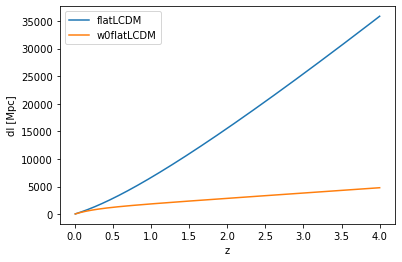

In [3]:
z_array = np.linspace(0.01,4,1000)
FLCDM_cosmo=icarogw.cosmologies.flatLCDM(H0=70,Omega_m=0.3)
w0FLCDM_cosmo=icarogw.cosmologies.w0flatLCDM(H0=70,Omega_m=0.3,w0=3)

plt.plot(z_array,FLCDM_cosmo.dl_at_z(z_array),label='flatLCDM')
plt.plot(z_array,w0FLCDM_cosmo.dl_at_z(z_array),label='w0flatLCDM')
plt.legend()
plt.xlabel('z')
plt.ylabel('dl [Mpc]')

## The populaiton priors

Icarogw also provides classes to calculate the population priors on source masses and redshift

### Population priors on masses

Icarogw containts 4 phenomenological models for the source masses. For more details see the documentation. These models can be used to calculate the probability $p_{\rm pop}(m_1,m_2)$ but also draw from it

In [4]:
# Nsamp = 10000 #Number of binaries you want to generate from the prior

# # Defines a mass grid where to compute the prior
# mass = np.linspace(5, 100, 1000)
# M1, M2 = np.meshgrid(mass,mass)

# # Models in icarogw
# # names=['BBH-powerlaw','BBH-broken-powerlaw','BBH-powerlaw-gaussian','BBH-powerlaw-double-gaussian']
# names=['BBH-powerlaw']
# for name in names:
    
#     # Initialize the models with some parameters. 
#     if name=='BBH-powerlaw':
#         dic_param = {'alpha':0,'beta':0,'mmin':5.,'mmax':100}
        

#     # Initialize the mass prior
#     mp = icarogw.priors.mass.mass_prior(name,hyper_params_dict=dic_param)
#     # Sample m1 and m2 from the mass prior and histogram it
#     _ = corner.corner(np.column_stack(mp.sample(Nsamp)),labels=[r'$m_{1,s}$',r'$m_{2,s}$'])
    
#     # Calculates p(m1,m2) on the grid of masses
#     ppp=mp.joint_prob(M1,M2)

#     # Calculates the marginal distributions from the grid
#     marg_m1=np.trapz(ppp,mass,axis=0)
#     marg_m2=np.trapz(ppp,mass,axis=1)

#     # Compares the histograms generated from the monte carlo draws and the analytical distributions
#     plt.figure()
#     plt.plot(mass,marg_m1,label='p(m1)')
#     plt.plot(mass,marg_m2,label='p(m2)')
#     plt.xlabel(r'$mass [M_{\odot}]$')
#     plt.ylabel(r'$PDF [M^{-1}_{\odot}]$')
#     plt.legend()

### Population priors on redshift

Icarogw also contains a class for redshif priors. We have two models available, see the documentation for more details

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:87: RuntimeWarning: divide by zero encountered in log
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:104: RuntimeWarning: divide by zero encountered in log
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:87: RuntimeWarning: divide by zero encountered in log
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:104: RuntimeWarning: divide b

Text(0, 0.5, 'Prior')

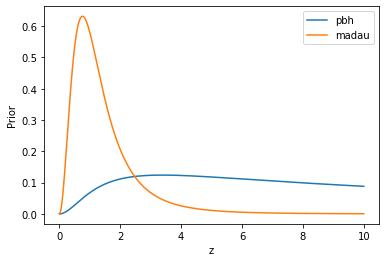

In [5]:
z_array = np.linspace(0,10,1000)
# Initialize the cosmology. This is needed for the redshift prior.
cosmo = icarogw.cosmologies.flatLCDM()

# Initialize the redshift prior, we are using the a powerlaw merger rate evolution model 
zp_pl = icarogw.priors.redshift.redshift_prior(cosmo, 'PBH', {})
# Plot the prior
plt.plot(z_array, zp_pl.prob(z_array), label='pbh')

# Initializethe redshift prior, we are using a Madau like rate evolution model
zp_pl = icarogw.priors.redshift.redshift_prior(cosmo,'madau', {'gamma':1.,'kappa':3.,'zp':0.5})
plt.plot(z_array,zp_pl.prob(z_array),label='madau')
plt.legend()
plt.xlabel('z')
plt.ylabel('Prior')


## Injections file creation and tests

Icarogw uses list of injections to evaluate selection biases but also number of expected signals for a given run. Below we are going to see how to calculate these numbers starting from a list of injections

In [6]:
# Uncomment to download in injection file from O2 and the LIGO and Virgo collaboration
# !wget https://dcc.ligo.org/public/0171/P2000434/003/injections_O1O2an_spin.h5

In [7]:
# The injection set that we are using is generated for a fixwed cosmology. Below we set the reference cosmology
H0_ref = 67.7 # H0 used for injections
Om0_ref = 0.308
cosmo_ref = icarogw.cosmologies.flatLCDM(Omega_m=Om0_ref,H0=H0_ref)

# We read the file
f2 = h5py.File('injections_O1O2an_spin.h5','r')

# Defines the time span in years of O1 and O2 considering a 60% duty cycle
tO1O2 = ((129+272)/365)*0.6
tot_time = tO1O2

# We need to tell the code how many signals we simulated, even the non detected ones
nO1O2=f2['sampling_pdf'].attrs['Ndraw']
ntot=nO1O2

# Extract the masses, redshift, redshift and priors used to draw the simulated signals. 
ms1 = f2['mass1_source'][()]
ms2 = f2['mass2_source'][()]
z= f2['redshift'][()]
snr_det= f2['snr_observed'][()]
far=np.ones_like(f2['snr_observed'])*np.inf # This injection set does not contain IFAR, so we set it to infinity
prior_vals=f2['sampling_pdf'][()]*4 # Multiply by 4 to remove the spin prior


injections = icarogw.injections.injections_at_source(cosmo_ref=cosmo_ref, m1s=ms1, m2s=ms2, z=z,
    prior_vals=prior_vals, snr_det=snr_det,
    snr_cut=12,ifar_cut=1,ifar=far, # Generate an injection set with a SNR cut for detection of 12 and IFAR cut of 1
    ntotal=ntot,Tobs=tot_time)

In [8]:
# We initialize here a prior model for redshift and mass

zp = icarogw.priors.redshift.redshift_prior(cosmo, 'PBH', {})
mass_hp = {'mc':20, 'σc':0.5}

mp = icarogw.priors.mass.mass_prior_pbh(name='PBH-lognormal', hyper_params_dict=mass_hp)

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:87: RuntimeWarning: divide by zero encountered in log


AttributeError: module 'icarogw.priors.mass' has no attribute 'mass_prior_pbh'

In [8]:
# # We update the injection model
# injections.update_VT(mp, zp)
# # We print the number of expected detections in O1 and O2 with SNR>12
# print(injections.expected_number_detection(80)) # 20= merger rate today in Gpc-3 yr-1

In [9]:
# # We can update the cut to an SNR cut of 11 ad check how many events more I expect
# injections.update_cut(snr_cut=11,ifar_cut=0)
# injections.update_VT(mp,zp)
# print(injections.expected_number_detection(100)) #20= merger rate today in Gpc-3 yr-1

# Analysis tests

In this part we are going to see how to perform some simple analysis based on O1 and O2 BBHs.

## Simple analysis on population grid

We are going to show how to run an analysis using discrete populaton models. In this case, we will just fix the population model for BBHs and run the analysis only on the Hubble constant

In [55]:
# Select all O1 and O2 BBHs with SNR cut>2
# list_ev = icarogw.utils.quick_init.initialize_events_dict(runs=['O1','O2','O3a','O3b'], type='BBH', snr_cut=8)
list_ev = icarogw.utils.quick_init.initialize_events_dict(runs=['O1','O2','O3a','O3b'],type=['BBH', 'SPECIAL'],snr_cut=11)
len(list_ev)

43

In [53]:
list_ev = icarogw.utils.quick_init.initialize_events_dict(runs=['O1','O2','O3a','O3b'],type=['BBH', 'SPECIAL'],snr_cut=11)
len(list_ev)

43

In [11]:
# Get the posterior samples, please uncomment these lines
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW151226_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170104_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170608_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170809_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170814_GWTC-1.hdf5

In [12]:
# import icarogw
from icarogw.posterior_samples import posterior_samples
# from icarogw.injections import injections_at_source
# from icarogw.priors.mass import mass_prior, mass_prior_pbh
# from icarogw.priors.redshift import redshift_prior
# from icarogw.cosmologies import flatLCDM
# from icarogw.analyses.cosmo_pop_rate_marginalized import hierarchical_analysis
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle


# H0_array=np.linspace(10,200,100) # H0 at which you want to study

# mass_hp = {'mc':20, 'σc':0.5}
# mp = mass_prior_pbh(name='PBH-lognormal', hyper_params_dict=mass_hp)
# mp_list = [mp for i in range(100)] # Defines a list of population priors for masses, all equal
# cosmo_list = [flatLCDM(H0=H0) for H0 in H0_array] # Defines a list of cosmology, here we are changing H0

# # zp_pl = [redshift_prior(cosmo,'powerlaw',{'gamma':0}) for cosmo in cosmo_list] # Defines a uniform in comoving volume prior
# zp_pl = [redshift_prior(cosmo, 'PBH-lognormal', {}) for cosmo in cosmo_list]

# injections.update_cut(snr_cut=12,ifar_cut=0) # We are going to update the injections with the new SNR cut to 12

# # Read the posterior samples
# posterior_dict = {}
# for event in list(list_ev.keys()):
#     print(event)    
#     filename = event+'_GWTC-1.hdf5'
        
#     pos_samples = posterior_samples(filename)
#     posterior_dict[event]=pos_samples
    
# analysis = hierarchical_analysis(posterior_dict, injections) # Initialize the analysis
# single_posterior = analysis.run_analysis_on_lists(mp_list, zp_pl) # Run the analysis on the list of population models

In [13]:
# # Just combining posteriors with this script. You might want to add a smoothing factor when multiplying posteriors
# combined = np.zeros(100)
# for key in list(single_posterior.keys()):
#     combined+=single_posterior[key]
#     combined-=combined.max()
#     single_posterior[key] = np.exp(single_posterior[key])
#     single_posterior[key]/= np.trapz(single_posterior[key],np.linspace(20,140,100))
#     plt.plot(np.linspace(10,200,100),single_posterior[key])
# combined=np.exp(combined)
# combined/=np.trapz(combined,np.linspace(20,140,100))
# plt.plot(np.linspace(10,200,100),combined)

## MCMC population analysis

Icarogw is also implemented with Bilby and can be used to run an MCMC sampling for more population parameters at the same time.

In [14]:
ls

 GW150914_GWTC-1.hdf5   GW170814_GWTC-1.hdf5              merger_rate.ipynb
 GW151226_GWTC-1.hdf5  'R_norm_mcs_'$'\317\203''c.jld2'   pbh_merger_rate.jl
 GW170104_GWTC-1.hdf5   Untitled.ipynb                    test.txt
 GW170608_GWTC-1.hdf5   injections_O1O2an_spin.h5         tutorial.ipynb
 GW170809_GWTC-1.hdf5  'mcs_'$'\317\203''c_RN.txt'        tutorial2.ipynb


In [15]:
import bilby as _bilby
import sys as _sys
import os as _os

def initialize_prior_dict(population, cosmology, rates, scale_free):
    '''
    This function initialize a prior dictionary to run bilby jobs with the hierarchical population anlysis

    Parameters
    ----------
    population: str
        The source-frame mass population model, either 'BBH-powerlaw', 'BBH-powerlaw-gaussian'
        'BBH-broken-powerlaw' or 'BBH-powerlaw-double-gaussian'
    cosmology: str
        The cosmological model, either 'flatLCDM', 'w0flatLCDM', 'w0waflatLCDM'
    rates: str
        The merger rate evolution model, either 'powerlaw' or 'madau'
    scale_free: boolean
        If false it will provide a prior also on the rate of merger today.

    Returns
    -------
    prior_dict: dict
        The prior dictionary
    '''
    prior_dict = {}

    if rates=='non-evolving':
        prior_dict['gamma'] = _bilby.core.prior.DeltaFunction(0,name='gamma')
    elif rates=='powerlaw':
        prior_dict['gamma'] = _bilby.core.prior.Uniform(-4,10,name='gamma')
        
    elif rates=='PBH':
        pass
    else:
        raise ValueError('Redshift model not known')

    if not scale_free:
        prior_dict['R0'] = _bilby.core.prior.Uniform(0,1000,name='R0')

    if population == 'BBH-powerlaw':
        prior_dict['alpha'] = _bilby.core.prior.Uniform(-4,12,name='alpha')
        prior_dict['beta'] = _bilby.core.prior.Uniform(-4,12,name='beta')
        prior_dict['mmax'] = _bilby.core.prior.Uniform(30,100,name='mmax')
        prior_dict['mmin'] = _bilby.core.prior.Uniform(2,10,name='mmin')
        
    elif population == 'PBH-lognormal':
        prior_dict['mc'] = _bilby.core.prior.Uniform(6.0, 60.0, name='mc')
        prior_dict['σc'] = _bilby.core.prior.Uniform(0.1, 2, name='σc')

    else:
        print('Prior model not implemented')
        _sys.exit()

    if cosmology == 'fixed-flatLCDM':
        prior_dict['H0'] = _bilby.core.prior.DeltaFunction(67.74,name='H0')
        prior_dict['Om0'] = _bilby.core.prior.DeltaFunction(0.3065,name='Om0')

    elif cosmology == 'flatLCDM':
        prior_dict['H0'] = _bilby.core.prior.Uniform(10, 200,name='H0')
        prior_dict['Om0'] = _bilby.core.prior.Uniform(0.0, 1.0,name='Om0')
    elif cosmology == 'w0flatLCDM':
        prior_dict['H0'] = _bilby.core.prior.Uniform(20,120,name='H0')
        prior_dict['Om0'] = _bilby.core.prior.Uniform(0.1,0.5,name='Om0')
        prior_dict['w0'] = _bilby.core.prior.Uniform(-3.0,0.,name='w0')
    else:
        print('Not implemented')
        _sys.exit()

    return prior_dict

In [16]:
# prior_dict

15:25 bilby INFO    : Running for label 'dynesty_3', output will be saved to 'H0_GWTC-1_PL_2/'
15:25 bilby INFO    : Search parameters:
15:25 bilby INFO    :   R0 = Uniform(minimum=0, maximum=1000, name='R0', latex_label='R0', unit=None, boundary=None)
15:25 bilby INFO    :   mc = Uniform(minimum=6.0, maximum=60.0, name='mc', latex_label='mc', unit=None, boundary=None)
15:25 bilby INFO    :   σc = Uniform(minimum=0.1, maximum=2, name='σc', latex_label='σc', unit=None, boundary=None)
15:25 bilby INFO    :   H0 = Uniform(minimum=10, maximum=200, name='H0', latex_label='H0', unit=None, boundary=None)
15:25 bilby INFO    :   Om0 = Uniform(minimum=0.0, maximum=1.0, name='Om0', latex_label='Om0', unit=None, boundary=None)


Selecting injections with SNR 12.000000 and IFAR 0.000000 yr
GW150914
Using Overall_posterior posterior with a total of 8350 samples
GW151226
Using Overall_posterior posterior with a total of 52252 samples
GW170104
Using Overall_posterior posterior with a total of 24972 samples
GW170608
Using Overall_posterior posterior with a total of 6448 samples
GW170809
Using Overall_posterior posterior with a total of 14802 samples
GW170814
Using Overall_posterior posterior with a total of 40000 samples
Using the parallel mode with 2000 samples


/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log
15:25 bilby INFO    : Single likelihood evaluation took 1.137e-02 s


0it [00:00, ?it/s]

15:25 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 20, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f218445a9a0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 2}
15:25 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:25 bilby INFO    : Using dynesty version 1.0.1
15:25 bilby INFO    : Using the bilby-implemented rwalk sampl

1681it [03:14,  1.98it/s, bound:0 nc: 57 ncall:1.7e+04 eff:10.0% logz=-156.67+/-0.12 dlogz:7.275>0.1] 

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1695it [03:18,  4.13it/s, bound:1 nc: 21 ncall:1.7e+04 eff:9.9% logz=-156.55+/-0.12 dlogz:7.131>0.1] 

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1710it [03:21,  4.18it/s, bound:2 nc: 21 ncall:1.7e+04 eff:9.8% logz=-156.43+/-0.12 dlogz:6.983>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1724it [03:25,  4.16it/s, bound:3 nc: 21 ncall:1.8e+04 eff:9.7% logz=-156.33+/-0.12 dlogz:6.849>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1737it [03:28,  3.87it/s, bound:4 nc: 21 ncall:1.8e+04 eff:9.6% logz=-156.23+/-0.12 dlogz:6.728>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1750it [03:32,  4.10it/s, bound:5 nc: 21 ncall:1.8e+04 eff:9.5% logz=-156.14+/-0.12 dlogz:6.610>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1765it [03:36,  4.18it/s, bound:6 nc: 21 ncall:1.9e+04 eff:9.4% logz=-156.04+/-0.12 dlogz:6.477>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1780it [03:39,  4.14it/s, bound:7 nc: 21 ncall:1.9e+04 eff:9.4% logz=-155.94+/-0.12 dlogz:6.351>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1793it [03:43,  3.84it/s, bound:8 nc: 21 ncall:1.9e+04 eff:9.3% logz=-155.86+/-0.12 dlogz:6.289>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1801it [03:47,  2.42it/s, bound:9 nc: 21 ncall:2.0e+04 eff:9.2% logz=-155.81+/-0.12 dlogz:6.225>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1809it [03:50,  2.48it/s, bound:10 nc: 29 ncall:2.0e+04 eff:9.1% logz=-155.77+/-0.12 dlogz:6.162>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1818it [03:54,  2.73it/s, bound:11 nc: 21 ncall:2.0e+04 eff:9.0% logz=-155.71+/-0.12 dlogz:6.091>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1827it [03:57,  2.53it/s, bound:12 nc: 23 ncall:2.1e+04 eff:8.9% logz=-155.66+/-0.12 dlogz:6.020>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1837it [04:01,  2.24it/s, bound:13 nc: 47 ncall:2.1e+04 eff:8.8% logz=-155.60+/-0.12 dlogz:5.942>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1847it [04:06,  1.86it/s, bound:14 nc: 94 ncall:2.1e+04 eff:8.7% logz=-155.54+/-0.12 dlogz:5.865>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1859it [04:09,  3.45it/s, bound:15 nc: 21 ncall:2.2e+04 eff:8.6% logz=-155.48+/-0.12 dlogz:5.774>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1870it [04:13,  2.21it/s, bound:16 nc: 61 ncall:2.2e+04 eff:8.5% logz=-155.42+/-0.12 dlogz:5.690>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1879it [04:17,  2.31it/s, bound:17 nc: 53 ncall:2.2e+04 eff:8.4% logz=-155.37+/-0.12 dlogz:5.624>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1887it [04:20,  2.42it/s, bound:18 nc: 21 ncall:2.3e+04 eff:8.4% logz=-155.32+/-0.12 dlogz:5.565>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1897it [04:24,  3.00it/s, bound:19 nc: 21 ncall:2.3e+04 eff:8.3% logz=-155.27+/-0.12 dlogz:5.493>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1906it [04:28,  2.28it/s, bound:20 nc: 40 ncall:2.3e+04 eff:8.2% logz=-155.23+/-0.12 dlogz:5.430>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1915it [04:31,  2.21it/s, bound:21 nc: 71 ncall:2.3e+04 eff:8.2% logz=-155.18+/-0.12 dlogz:5.368>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1925it [04:35,  2.17it/s, bound:22 nc: 52 ncall:2.4e+04 eff:8.1% logz=-155.13+/-0.12 dlogz:5.299>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1937it [04:39,  3.24it/s, bound:23 nc: 31 ncall:2.4e+04 eff:8.0% logz=-155.07+/-0.12 dlogz:5.217>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1942it [04:43,  1.45it/s, bound:24 nc: 91 ncall:2.4e+04 eff:7.9% logz=-155.05+/-0.12 dlogz:5.183>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1950it [04:46,  2.06it/s, bound:25 nc: 58 ncall:2.5e+04 eff:7.9% logz=-155.01+/-0.12 dlogz:5.129>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1952it [04:48,  1.73it/s, bound:26 nc: 21 ncall:2.5e+04 eff:7.8% logz=-155.00+/-0.12 dlogz:5.115>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/mass.py:40: RuntimeWarning: divide by zero encountered in log


1956it [04:50,  1.77it/s, bound:26 nc: 64 ncall:2.5e+04 eff:7.8% logz=-154.98+/-0.12 dlogz:5.089>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1967it [04:54,  3.16it/s, bound:27 nc: 21 ncall:2.5e+04 eff:7.7% logz=-154.93+/-0.12 dlogz:5.016>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1972it [04:57,  1.26it/s, bound:28 nc:105 ncall:2.6e+04 eff:7.7% logz=-154.91+/-0.12 dlogz:4.984>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1979it [05:01,  2.05it/s, bound:29 nc: 47 ncall:2.6e+04 eff:7.6% logz=-154.88+/-0.12 dlogz:4.938>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1988it [05:05,  1.56it/s, bound:30 nc:120 ncall:2.6e+04 eff:7.5% logz=-154.84+/-0.12 dlogz:4.881>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


1995it [05:09,  1.58it/s, bound:31 nc: 42 ncall:2.7e+04 eff:7.4% logz=-154.81+/-0.12 dlogz:4.836>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2004it [05:13,  1.40it/s, bound:32 nc:112 ncall:2.7e+04 eff:7.4% logz=-154.77+/-0.12 dlogz:4.779>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2012it [05:17,  1.59it/s, bound:33 nc: 88 ncall:2.8e+04 eff:7.3% logz=-154.73+/-0.12 dlogz:4.730>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2019it [05:21,  1.59it/s, bound:34 nc: 76 ncall:2.8e+04 eff:7.3% logz=-154.70+/-0.12 dlogz:4.687>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2024it [05:24,  1.29it/s, bound:35 nc:108 ncall:2.8e+04 eff:7.2% logz=-154.68+/-0.12 dlogz:4.656>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2030it [05:28,  1.61it/s, bound:36 nc: 79 ncall:2.8e+04 eff:7.1% logz=-154.66+/-0.12 dlogz:4.620>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2036it [05:31,  1.41it/s, bound:37 nc: 89 ncall:2.9e+04 eff:7.1% logz=-154.64+/-0.12 dlogz:4.584>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2042it [05:35,  1.60it/s, bound:38 nc: 40 ncall:2.9e+04 eff:7.0% logz=-154.61+/-0.12 dlogz:4.548>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2048it [05:39,  1.50it/s, bound:39 nc: 46 ncall:2.9e+04 eff:7.0% logz=-154.59+/-0.12 dlogz:4.511>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2053it [05:43,  1.47it/s, bound:40 nc: 60 ncall:3.0e+04 eff:6.9% logz=-154.56+/-0.12 dlogz:4.480>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2061it [05:47,  1.81it/s, bound:41 nc: 61 ncall:3.0e+04 eff:6.8% logz=-154.53+/-0.12 dlogz:4.432>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2068it [05:50,  2.07it/s, bound:42 nc: 25 ncall:3.0e+04 eff:6.8% logz=-154.50+/-0.12 dlogz:4.390>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2074it [05:53,  2.21it/s, bound:43 nc: 21 ncall:3.1e+04 eff:6.8% logz=-154.48+/-0.12 dlogz:4.354>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2080it [05:57,  1.62it/s, bound:44 nc: 65 ncall:3.1e+04 eff:6.7% logz=-154.45+/-0.12 dlogz:4.318>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2088it [06:02,  1.52it/s, bound:45 nc:105 ncall:3.1e+04 eff:6.6% logz=-154.42+/-0.12 dlogz:4.271>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2092it [06:06,  1.08s/it, bound:46 nc:112 ncall:3.2e+04 eff:6.6% logz=-154.41+/-0.12 dlogz:4.248>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2096it [06:10,  1.06it/s, bound:47 nc: 64 ncall:3.2e+04 eff:6.5% logz=-154.39+/-0.12 dlogz:4.225>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2100it [06:12,  1.79it/s, bound:48 nc: 21 ncall:3.2e+04 eff:6.5% logz=-154.38+/-0.12 dlogz:4.201>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/mass.py:40: RuntimeWarning: divide by zero encountered in log


2102it [06:13,  1.44it/s, bound:48 nc: 87 ncall:3.2e+04 eff:6.5% logz=-154.37+/-0.12 dlogz:4.190>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2110it [06:17,  1.89it/s, bound:49 nc: 52 ncall:3.3e+04 eff:6.4% logz=-154.34+/-0.12 dlogz:4.143>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2116it [06:21,  1.72it/s, bound:50 nc: 42 ncall:3.3e+04 eff:6.4% logz=-154.31+/-0.12 dlogz:4.108>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2122it [06:25,  1.54it/s, bound:51 nc: 45 ncall:3.3e+04 eff:6.4% logz=-154.29+/-0.12 dlogz:4.073>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2127it [06:29,  1.16it/s, bound:52 nc: 61 ncall:3.4e+04 eff:6.3% logz=-154.27+/-0.12 dlogz:4.044>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2135it [06:33,  1.81it/s, bound:53 nc: 21 ncall:3.4e+04 eff:6.3% logz=-154.24+/-0.12 dlogz:3.999>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2143it [06:36,  2.43it/s, bound:54 nc: 21 ncall:3.4e+04 eff:6.2% logz=-154.21+/-0.12 dlogz:3.954>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2147it [06:40,  1.04it/s, bound:55 nc: 86 ncall:3.5e+04 eff:6.2% logz=-154.19+/-0.12 dlogz:3.931>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2152it [06:44,  1.27it/s, bound:56 nc: 63 ncall:3.5e+04 eff:6.1% logz=-154.18+/-0.12 dlogz:3.904>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2156it [06:48,  1.13it/s, bound:57 nc: 96 ncall:3.5e+04 eff:6.1% logz=-154.16+/-0.12 dlogz:3.882>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2160it [06:52,  1.09it/s, bound:58 nc: 76 ncall:3.6e+04 eff:6.0% logz=-154.15+/-0.12 dlogz:3.860>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2165it [06:56,  1.04it/s, bound:59 nc:134 ncall:3.6e+04 eff:6.0% logz=-154.13+/-0.12 dlogz:3.832>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2173it [07:00,  1.64it/s, bound:60 nc: 88 ncall:3.6e+04 eff:6.0% logz=-154.10+/-0.12 dlogz:3.789>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2179it [07:04,  1.28it/s, bound:61 nc: 69 ncall:3.7e+04 eff:5.9% logz=-154.08+/-0.12 dlogz:3.757>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2183it [07:08,  1.20it/s, bound:62 nc: 56 ncall:3.7e+04 eff:5.9% logz=-154.07+/-0.12 dlogz:3.736>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2190it [07:12,  1.57it/s, bound:63 nc: 82 ncall:3.7e+04 eff:5.8% logz=-154.04+/-0.12 dlogz:3.699>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2195it [07:15,  1.32it/s, bound:64 nc: 85 ncall:3.8e+04 eff:5.8% logz=-154.03+/-0.12 dlogz:3.673>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2201it [07:19,  1.71it/s, bound:65 nc: 58 ncall:3.8e+04 eff:5.8% logz=-154.01+/-0.12 dlogz:3.642>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2206it [07:22,  1.28it/s, bound:66 nc: 89 ncall:3.8e+04 eff:5.7% logz=-153.99+/-0.12 dlogz:3.616>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2213it [07:27,  1.30it/s, bound:67 nc: 96 ncall:3.9e+04 eff:5.7% logz=-153.97+/-0.12 dlogz:3.580>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2219it [07:30,  1.67it/s, bound:68 nc: 49 ncall:3.9e+04 eff:5.7% logz=-153.95+/-0.12 dlogz:3.550>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2230it [07:34,  3.10it/s, bound:69 nc: 21 ncall:3.9e+04 eff:5.7% logz=-153.91+/-0.12 dlogz:3.494>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2243it [07:38,  3.62it/s, bound:70 nc: 24 ncall:4.0e+04 eff:5.6% logz=-153.87+/-0.12 dlogz:3.429>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2255it [07:41,  3.14it/s, bound:71 nc: 28 ncall:4.0e+04 eff:5.6% logz=-153.83+/-0.12 dlogz:3.370>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2266it [07:45,  2.88it/s, bound:72 nc: 30 ncall:4.0e+04 eff:5.6% logz=-153.80+/-0.12 dlogz:3.316>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2275it [07:49,  2.60it/s, bound:73 nc: 30 ncall:4.1e+04 eff:5.6% logz=-153.77+/-0.12 dlogz:3.271>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2283it [07:52,  2.13it/s, bound:74 nc: 48 ncall:4.1e+04 eff:5.6% logz=-153.75+/-0.12 dlogz:3.232>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2290it [07:56,  2.07it/s, bound:75 nc: 41 ncall:4.1e+04 eff:5.5% logz=-153.73+/-0.12 dlogz:3.198>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2297it [07:59,  1.87it/s, bound:76 nc: 46 ncall:4.2e+04 eff:5.5% logz=-153.70+/-0.12 dlogz:3.164>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2304it [08:03,  2.10it/s, bound:77 nc: 38 ncall:4.2e+04 eff:5.5% logz=-153.68+/-0.12 dlogz:3.131>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2312it [08:06,  2.30it/s, bound:78 nc: 38 ncall:4.2e+04 eff:5.5% logz=-153.66+/-0.12 dlogz:3.093>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2319it [08:10,  1.94it/s, bound:79 nc: 61 ncall:4.3e+04 eff:5.4% logz=-153.64+/-0.12 dlogz:3.060>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2322it [08:15,  1.31s/it, bound:80 nc:186 ncall:4.3e+04 eff:5.4% logz=-153.63+/-0.12 dlogz:3.047>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2332it [08:19,  2.22it/s, bound:81 nc: 40 ncall:4.3e+04 eff:5.4% logz=-153.60+/-0.12 dlogz:3.001>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2340it [08:22,  2.54it/s, bound:82 nc: 31 ncall:4.4e+04 eff:5.4% logz=-153.58+/-0.12 dlogz:2.964>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2349it [08:25,  2.68it/s, bound:83 nc: 38 ncall:4.4e+04 eff:5.3% logz=-153.56+/-0.12 dlogz:2.923>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2357it [08:29,  2.29it/s, bound:84 nc: 36 ncall:4.4e+04 eff:5.3% logz=-153.53+/-0.12 dlogz:2.888>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2364it [08:32,  1.93it/s, bound:85 nc: 47 ncall:4.5e+04 eff:5.3% logz=-153.51+/-0.12 dlogz:2.856>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2368it [08:36,  1.11it/s, bound:86 nc:142 ncall:4.5e+04 eff:5.3% logz=-153.50+/-0.12 dlogz:2.838>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2372it [08:41,  1.29s/it, bound:87 nc:211 ncall:4.5e+04 eff:5.2% logz=-153.49+/-0.12 dlogz:2.821>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2380it [08:45,  1.68it/s, bound:88 nc: 44 ncall:4.6e+04 eff:5.2% logz=-153.47+/-0.12 dlogz:2.785>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2387it [08:48,  1.94it/s, bound:89 nc: 55 ncall:4.6e+04 eff:5.2% logz=-153.45+/-0.12 dlogz:2.755>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2394it [08:52,  1.96it/s, bound:90 nc: 39 ncall:4.6e+04 eff:5.2% logz=-153.43+/-0.12 dlogz:2.724>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2401it [08:56,  1.81it/s, bound:91 nc: 52 ncall:4.7e+04 eff:5.1% logz=-153.42+/-0.12 dlogz:2.694>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2404it [09:00,  1.09s/it, bound:92 nc:131 ncall:4.7e+04 eff:5.1% logz=-153.41+/-0.12 dlogz:2.682>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2407it [09:03,  1.18s/it, bound:93 nc:113 ncall:4.7e+04 eff:5.1% logz=-153.40+/-0.12 dlogz:2.669>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2410it [09:07,  1.15s/it, bound:94 nc: 90 ncall:4.8e+04 eff:5.1% logz=-153.39+/-0.12 dlogz:2.656>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2413it [09:11,  1.24s/it, bound:95 nc:113 ncall:4.8e+04 eff:5.0% logz=-153.39+/-0.12 dlogz:2.644>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2417it [09:14,  1.02it/s, bound:96 nc: 81 ncall:4.8e+04 eff:5.0% logz=-153.38+/-0.12 dlogz:2.627>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2421it [09:18,  1.08it/s, bound:97 nc: 71 ncall:4.9e+04 eff:5.0% logz=-153.37+/-0.12 dlogz:2.610>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2425it [09:22,  1.01it/s, bound:98 nc:107 ncall:4.9e+04 eff:4.9% logz=-153.36+/-0.12 dlogz:2.594>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2429it [09:26,  1.11it/s, bound:99 nc: 61 ncall:4.9e+04 eff:4.9% logz=-153.35+/-0.12 dlogz:2.577>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2433it [09:30,  1.08it/s, bound:100 nc: 94 ncall:5.0e+04 eff:4.9% logz=-153.34+/-0.12 dlogz:2.560>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2438it [09:33,  1.25it/s, bound:101 nc: 60 ncall:5.0e+04 eff:4.9% logz=-153.32+/-0.12 dlogz:2.540>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2442it [09:37,  1.10it/s, bound:102 nc: 60 ncall:5.0e+04 eff:4.9% logz=-153.31+/-0.12 dlogz:2.523>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2447it [09:41,  1.27it/s, bound:103 nc: 70 ncall:5.1e+04 eff:4.8% logz=-153.30+/-0.12 dlogz:2.503>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2453it [09:46,  1.14it/s, bound:104 nc:128 ncall:5.1e+04 eff:4.8% logz=-153.29+/-0.13 dlogz:2.479>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2457it [09:50,  1.11s/it, bound:105 nc:158 ncall:5.1e+04 eff:4.8% logz=-153.28+/-0.13 dlogz:2.463>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2462it [09:54,  1.30it/s, bound:106 nc: 51 ncall:5.2e+04 eff:4.8% logz=-153.27+/-0.13 dlogz:2.443>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2468it [09:57,  1.62it/s, bound:107 nc: 45 ncall:5.2e+04 eff:4.7% logz=-153.25+/-0.13 dlogz:2.419>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2473it [10:01,  1.49it/s, bound:108 nc: 38 ncall:5.2e+04 eff:4.7% logz=-153.24+/-0.13 dlogz:2.400>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2477it [10:04,  1.17it/s, bound:109 nc: 85 ncall:5.3e+04 eff:4.7% logz=-153.23+/-0.13 dlogz:2.384>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2483it [10:08,  1.62it/s, bound:110 nc: 55 ncall:5.3e+04 eff:4.7% logz=-153.22+/-0.13 dlogz:2.361>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2487it [10:11,  1.31it/s, bound:111 nc: 63 ncall:5.3e+04 eff:4.7% logz=-153.21+/-0.13 dlogz:2.345>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2491it [10:15,  1.20it/s, bound:112 nc: 70 ncall:5.4e+04 eff:4.6% logz=-153.20+/-0.13 dlogz:2.330>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2493it [10:16,  1.31it/s, bound:113 nc: 54 ncall:5.4e+04 eff:4.6% logz=-153.19+/-0.13 dlogz:2.322>0.1]

15:36 bilby INFO    : Written checkpoint file H0_GWTC-1_PL_2//dynesty_3_resume.pickle
15:36 bilby INFO    : Writing 201 current samples to H0_GWTC-1_PL_2//dynesty_3_samples.dat
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2496it [10:20,  1.06it/s, bound:113 nc: 66 ncall:5.4e+04 eff:4.6% logz=-153.19+/-0.13 dlogz:2.310>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2500it [10:23,  1.16it/s, bound:114 nc: 73 ncall:5.4e+04 eff:4.6% logz=-153.18+/-0.13 dlogz:2.295>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2506it [10:27,  1.56it/s, bound:115 nc: 50 ncall:5.5e+04 eff:4.6% logz=-153.17+/-0.13 dlogz:2.272>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2516it [10:31,  2.79it/s, bound:116 nc: 28 ncall:5.5e+04 eff:4.6% logz=-153.14+/-0.13 dlogz:2.235>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2519it [10:35,  1.11it/s, bound:117 nc:104 ncall:5.5e+04 eff:4.6% logz=-153.14+/-0.13 dlogz:2.224>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2530it [10:38,  2.60it/s, bound:118 nc: 38 ncall:5.6e+04 eff:4.5% logz=-153.11+/-0.13 dlogz:2.183>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2538it [10:42,  1.96it/s, bound:119 nc: 57 ncall:5.6e+04 eff:4.5% logz=-153.10+/-0.13 dlogz:2.154>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2544it [10:46,  1.65it/s, bound:120 nc: 56 ncall:5.6e+04 eff:4.5% logz=-153.08+/-0.13 dlogz:2.133>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2550it [10:49,  1.65it/s, bound:121 nc: 48 ncall:5.7e+04 eff:4.5% logz=-153.07+/-0.13 dlogz:2.111>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2556it [10:53,  1.50it/s, bound:122 nc: 83 ncall:5.7e+04 eff:4.5% logz=-153.06+/-0.13 dlogz:2.090>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2563it [10:57,  1.94it/s, bound:123 nc: 36 ncall:5.7e+04 eff:4.5% logz=-153.05+/-0.13 dlogz:2.066>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2571it [11:00,  2.50it/s, bound:124 nc: 27 ncall:5.8e+04 eff:4.5% logz=-153.03+/-0.13 dlogz:2.038>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2578it [11:04,  1.90it/s, bound:125 nc: 52 ncall:5.8e+04 eff:4.5% logz=-153.02+/-0.13 dlogz:2.014>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2585it [11:08,  2.02it/s, bound:126 nc: 53 ncall:5.8e+04 eff:4.4% logz=-153.00+/-0.13 dlogz:1.990>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2593it [11:11,  2.08it/s, bound:127 nc: 47 ncall:5.9e+04 eff:4.4% logz=-152.99+/-0.13 dlogz:1.963>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2600it [11:15,  1.64it/s, bound:128 nc: 68 ncall:5.9e+04 eff:4.4% logz=-152.97+/-0.13 dlogz:1.939>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2607it [11:19,  1.85it/s, bound:129 nc: 50 ncall:5.9e+04 eff:4.4% logz=-152.96+/-0.13 dlogz:1.916>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2610it [11:23,  1.02s/it, bound:130 nc:107 ncall:6.0e+04 eff:4.4% logz=-152.95+/-0.13 dlogz:1.906>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2614it [11:27,  1.05it/s, bound:131 nc: 89 ncall:6.0e+04 eff:4.4% logz=-152.95+/-0.13 dlogz:1.893>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2618it [11:31,  1.01s/it, bound:132 nc: 90 ncall:6.0e+04 eff:4.3% logz=-152.94+/-0.13 dlogz:1.879>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2622it [11:35,  1.05s/it, bound:133 nc: 89 ncall:6.1e+04 eff:4.3% logz=-152.93+/-0.13 dlogz:1.866>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2625it [11:38,  1.13s/it, bound:134 nc:104 ncall:6.1e+04 eff:4.3% logz=-152.93+/-0.13 dlogz:1.857>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2629it [11:42,  1.08it/s, bound:135 nc: 58 ncall:6.1e+04 eff:4.3% logz=-152.92+/-0.13 dlogz:1.844>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2633it [11:46,  1.05it/s, bound:136 nc: 75 ncall:6.2e+04 eff:4.3% logz=-152.91+/-0.13 dlogz:1.831>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2638it [11:52,  1.18s/it, bound:137 nc: 63 ncall:6.2e+04 eff:4.3% logz=-152.90+/-0.13 dlogz:1.815>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2643it [11:58,  1.07s/it, bound:138 nc: 54 ncall:6.2e+04 eff:4.2% logz=-152.90+/-0.13 dlogz:1.800>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2647it [12:03,  1.15s/it, bound:139 nc:109 ncall:6.3e+04 eff:4.2% logz=-152.89+/-0.13 dlogz:1.787>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2651it [12:07,  1.09s/it, bound:140 nc:106 ncall:6.3e+04 eff:4.2% logz=-152.88+/-0.13 dlogz:1.775>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2656it [12:11,  1.20it/s, bound:141 nc: 54 ncall:6.3e+04 eff:4.2% logz=-152.87+/-0.13 dlogz:1.759>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2661it [12:15,  1.21it/s, bound:142 nc: 57 ncall:6.4e+04 eff:4.2% logz=-152.86+/-0.13 dlogz:1.744>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2666it [12:20,  1.17it/s, bound:143 nc: 63 ncall:6.4e+04 eff:4.2% logz=-152.86+/-0.13 dlogz:1.729>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2671it [12:24,  1.24it/s, bound:144 nc: 67 ncall:6.4e+04 eff:4.2% logz=-152.85+/-0.13 dlogz:1.714>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2677it [12:28,  1.32it/s, bound:145 nc: 59 ncall:6.5e+04 eff:4.1% logz=-152.84+/-0.13 dlogz:1.696>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2689it [12:32,  2.61it/s, bound:146 nc: 32 ncall:6.5e+04 eff:4.1% logz=-152.82+/-0.13 dlogz:1.660>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2693it [12:36,  1.18it/s, bound:147 nc: 79 ncall:6.5e+04 eff:4.1% logz=-152.81+/-0.13 dlogz:1.649>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2698it [12:41,  1.21it/s, bound:148 nc: 82 ncall:6.6e+04 eff:4.1% logz=-152.80+/-0.13 dlogz:1.634>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2704it [12:44,  1.68it/s, bound:149 nc: 48 ncall:6.6e+04 eff:4.1% logz=-152.79+/-0.13 dlogz:1.617>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2712it [12:48,  2.04it/s, bound:150 nc: 33 ncall:6.6e+04 eff:4.1% logz=-152.78+/-0.13 dlogz:1.594>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2720it [12:52,  1.83it/s, bound:151 nc: 47 ncall:6.7e+04 eff:4.1% logz=-152.77+/-0.13 dlogz:1.572>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2728it [12:56,  2.07it/s, bound:152 nc: 42 ncall:6.7e+04 eff:4.1% logz=-152.76+/-0.13 dlogz:1.549>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2732it [13:00,  1.04it/s, bound:153 nc: 97 ncall:6.7e+04 eff:4.1% logz=-152.75+/-0.13 dlogz:1.538>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2736it [13:04,  1.03it/s, bound:154 nc: 79 ncall:6.8e+04 eff:4.0% logz=-152.74+/-0.13 dlogz:1.527>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2740it [13:08,  1.04it/s, bound:155 nc: 62 ncall:6.8e+04 eff:4.0% logz=-152.74+/-0.13 dlogz:1.516>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2744it [13:13,  1.25s/it, bound:156 nc: 78 ncall:6.8e+04 eff:4.0% logz=-152.73+/-0.13 dlogz:1.505>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2748it [13:20,  1.50s/it, bound:157 nc: 93 ncall:6.9e+04 eff:4.0% logz=-152.73+/-0.13 dlogz:1.494>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2752it [13:24,  1.16s/it, bound:158 nc: 74 ncall:6.9e+04 eff:4.0% logz=-152.72+/-0.13 dlogz:1.484>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2757it [13:29,  1.06it/s, bound:159 nc: 61 ncall:6.9e+04 eff:4.0% logz=-152.71+/-0.13 dlogz:1.524>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2761it [13:33,  1.06s/it, bound:160 nc: 80 ncall:7.0e+04 eff:4.0% logz=-152.71+/-0.13 dlogz:1.513>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2766it [13:38,  1.06it/s, bound:161 nc: 69 ncall:7.0e+04 eff:4.0% logz=-152.70+/-0.13 dlogz:1.500>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2776it [13:42,  2.18it/s, bound:162 nc: 41 ncall:7.0e+04 eff:3.9% logz=-152.69+/-0.13 dlogz:1.473>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2785it [13:46,  2.15it/s, bound:163 nc: 50 ncall:7.1e+04 eff:3.9% logz=-152.67+/-0.13 dlogz:1.450>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2793it [13:50,  2.03it/s, bound:164 nc: 40 ncall:7.1e+04 eff:3.9% logz=-152.66+/-0.13 dlogz:1.429>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2800it [13:54,  1.64it/s, bound:165 nc: 45 ncall:7.1e+04 eff:3.9% logz=-152.65+/-0.13 dlogz:1.411>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2808it [13:59,  1.77it/s, bound:166 nc: 44 ncall:7.2e+04 eff:3.9% logz=-152.64+/-0.13 dlogz:1.391>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2815it [14:03,  1.54it/s, bound:167 nc: 55 ncall:7.2e+04 eff:3.9% logz=-152.63+/-0.13 dlogz:1.373>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2822it [14:07,  1.73it/s, bound:168 nc: 40 ncall:7.2e+04 eff:3.9% logz=-152.62+/-0.13 dlogz:1.356>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2829it [14:11,  1.83it/s, bound:169 nc: 33 ncall:7.3e+04 eff:3.9% logz=-152.61+/-0.13 dlogz:1.338>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2835it [14:15,  1.68it/s, bound:170 nc: 40 ncall:7.3e+04 eff:3.9% logz=-152.61+/-0.13 dlogz:1.324>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2842it [14:19,  1.55it/s, bound:171 nc: 53 ncall:7.3e+04 eff:3.9% logz=-152.60+/-0.13 dlogz:1.307>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2847it [14:24,  1.18it/s, bound:172 nc: 65 ncall:7.4e+04 eff:3.9% logz=-152.59+/-0.13 dlogz:1.295>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2854it [14:28,  1.43it/s, bound:173 nc: 73 ncall:7.4e+04 eff:3.9% logz=-152.58+/-0.13 dlogz:1.279>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2862it [14:32,  1.94it/s, bound:174 nc: 35 ncall:7.4e+04 eff:3.9% logz=-152.57+/-0.13 dlogz:1.260>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2870it [14:36,  1.89it/s, bound:175 nc: 49 ncall:7.5e+04 eff:3.8% logz=-152.56+/-0.13 dlogz:1.241>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2877it [14:40,  1.91it/s, bound:176 nc: 39 ncall:7.5e+04 eff:3.8% logz=-152.55+/-0.13 dlogz:1.225>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2885it [14:44,  2.18it/s, bound:177 nc: 37 ncall:7.5e+04 eff:3.8% logz=-152.54+/-0.13 dlogz:1.207>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2893it [14:47,  2.27it/s, bound:178 nc: 37 ncall:7.6e+04 eff:3.8% logz=-152.53+/-0.13 dlogz:1.190>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2901it [14:51,  2.32it/s, bound:179 nc: 33 ncall:7.6e+04 eff:3.8% logz=-152.52+/-0.13 dlogz:1.172>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2909it [14:54,  2.35it/s, bound:180 nc: 31 ncall:7.6e+04 eff:3.8% logz=-152.52+/-0.13 dlogz:1.155>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2916it [14:58,  1.94it/s, bound:181 nc: 47 ncall:7.6e+04 eff:3.8% logz=-152.51+/-0.13 dlogz:1.140>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2923it [15:01,  1.89it/s, bound:182 nc: 52 ncall:7.7e+04 eff:3.8% logz=-152.50+/-0.13 dlogz:1.125>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2931it [15:05,  1.95it/s, bound:183 nc: 47 ncall:7.7e+04 eff:3.8% logz=-152.49+/-0.13 dlogz:1.108>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2937it [15:09,  1.59it/s, bound:184 nc: 39 ncall:7.7e+04 eff:3.8% logz=-152.48+/-0.13 dlogz:1.096>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2944it [15:13,  1.81it/s, bound:185 nc: 47 ncall:7.8e+04 eff:3.8% logz=-152.48+/-0.13 dlogz:1.082>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2950it [15:16,  1.68it/s, bound:186 nc: 53 ncall:7.8e+04 eff:3.8% logz=-152.47+/-0.13 dlogz:1.070>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2956it [15:20,  1.80it/s, bound:187 nc: 45 ncall:7.8e+04 eff:3.8% logz=-152.46+/-0.13 dlogz:1.057>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2963it [15:23,  1.96it/s, bound:188 nc: 44 ncall:7.9e+04 eff:3.8% logz=-152.46+/-0.13 dlogz:1.044>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2970it [15:27,  1.82it/s, bound:189 nc: 55 ncall:7.9e+04 eff:3.8% logz=-152.45+/-0.13 dlogz:1.030>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2976it [15:30,  1.57it/s, bound:190 nc: 86 ncall:7.9e+04 eff:3.7% logz=-152.44+/-0.13 dlogz:1.018>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2983it [15:34,  1.85it/s, bound:191 nc: 41 ncall:8.0e+04 eff:3.7% logz=-152.44+/-0.13 dlogz:1.005>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2990it [15:38,  1.70it/s, bound:192 nc: 56 ncall:8.0e+04 eff:3.7% logz=-152.43+/-0.13 dlogz:0.992>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


2996it [15:42,  1.69it/s, bound:193 nc: 49 ncall:8.0e+04 eff:3.7% logz=-152.42+/-0.13 dlogz:0.980>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3003it [15:45,  1.82it/s, bound:194 nc: 47 ncall:8.1e+04 eff:3.7% logz=-152.42+/-0.13 dlogz:0.967>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3009it [15:49,  1.65it/s, bound:195 nc: 62 ncall:8.1e+04 eff:3.7% logz=-152.41+/-0.13 dlogz:0.956>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3016it [15:53,  1.67it/s, bound:196 nc: 58 ncall:8.1e+04 eff:3.7% logz=-152.40+/-0.13 dlogz:0.944>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3022it [15:57,  1.59it/s, bound:197 nc: 54 ncall:8.2e+04 eff:3.7% logz=-152.40+/-0.13 dlogz:0.933>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3028it [16:01,  1.57it/s, bound:198 nc: 58 ncall:8.2e+04 eff:3.7% logz=-152.39+/-0.13 dlogz:0.922>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3034it [16:04,  1.72it/s, bound:199 nc: 50 ncall:8.2e+04 eff:3.7% logz=-152.39+/-0.13 dlogz:0.911>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3041it [16:08,  1.97it/s, bound:200 nc: 40 ncall:8.3e+04 eff:3.7% logz=-152.38+/-0.13 dlogz:0.899>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3045it [16:12,  1.02s/it, bound:201 nc:115 ncall:8.3e+04 eff:3.7% logz=-152.38+/-0.13 dlogz:0.892>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3048it [16:16,  1.16s/it, bound:202 nc:121 ncall:8.3e+04 eff:3.7% logz=-152.37+/-0.13 dlogz:0.887>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3052it [16:20,  1.04it/s, bound:203 nc: 80 ncall:8.4e+04 eff:3.6% logz=-152.37+/-0.13 dlogz:0.880>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3057it [16:24,  1.06it/s, bound:204 nc: 95 ncall:8.4e+04 eff:3.6% logz=-152.37+/-0.13 dlogz:0.872>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3066it [16:28,  2.02it/s, bound:205 nc: 61 ncall:8.4e+04 eff:3.6% logz=-152.36+/-0.13 dlogz:0.857>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3075it [16:32,  2.38it/s, bound:206 nc: 36 ncall:8.5e+04 eff:3.6% logz=-152.35+/-0.13 dlogz:0.842>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3079it [16:35,  1.25it/s, bound:207 nc: 90 ncall:8.5e+04 eff:3.6% logz=-152.35+/-0.13 dlogz:0.836>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3084it [16:42,  1.55s/it, bound:208 nc: 82 ncall:8.5e+04 eff:3.6% logz=-152.34+/-0.13 dlogz:0.828>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3089it [16:51,  1.54s/it, bound:209 nc: 54 ncall:8.6e+04 eff:3.6% logz=-152.34+/-0.13 dlogz:0.824>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3094it [16:58,  1.50s/it, bound:210 nc: 44 ncall:8.6e+04 eff:3.6% logz=-152.33+/-0.13 dlogz:0.816>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3100it [17:06,  1.19s/it, bound:211 nc: 42 ncall:8.6e+04 eff:3.6% logz=-152.33+/-0.13 dlogz:0.807>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3105it [17:16,  1.94s/it, bound:212 nc: 96 ncall:8.7e+04 eff:3.6% logz=-152.32+/-0.13 dlogz:0.799>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3111it [17:22,  1.05s/it, bound:213 nc: 42 ncall:8.7e+04 eff:3.6% logz=-152.32+/-0.13 dlogz:0.790>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3116it [17:28,  1.22s/it, bound:214 nc: 86 ncall:8.7e+04 eff:3.6% logz=-152.32+/-0.13 dlogz:0.782>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3122it [17:35,  1.26s/it, bound:215 nc: 66 ncall:8.8e+04 eff:3.6% logz=-152.31+/-0.13 dlogz:0.773>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3129it [17:42,  1.13s/it, bound:216 nc: 51 ncall:8.8e+04 eff:3.6% logz=-152.30+/-0.13 dlogz:0.763>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3135it [17:50,  1.31s/it, bound:217 nc: 84 ncall:8.8e+04 eff:3.5% logz=-152.30+/-0.13 dlogz:0.754>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3140it [17:57,  1.22s/it, bound:218 nc: 44 ncall:8.9e+04 eff:3.5% logz=-152.30+/-0.13 dlogz:0.746>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3145it [18:03,  1.29s/it, bound:219 nc: 70 ncall:8.9e+04 eff:3.5% logz=-152.29+/-0.13 dlogz:0.739>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3151it [18:10,  1.23s/it, bound:220 nc: 40 ncall:8.9e+04 eff:3.5% logz=-152.29+/-0.13 dlogz:0.730>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3156it [18:17,  1.35s/it, bound:221 nc: 69 ncall:9.0e+04 eff:3.5% logz=-152.28+/-0.13 dlogz:0.723>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3161it [18:24,  1.32s/it, bound:222 nc: 77 ncall:9.0e+04 eff:3.5% logz=-152.28+/-0.13 dlogz:0.716>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3167it [18:31,  1.24s/it, bound:223 nc: 62 ncall:9.0e+04 eff:3.5% logz=-152.28+/-0.13 dlogz:0.708>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3172it [18:38,  1.31s/it, bound:224 nc: 72 ncall:9.1e+04 eff:3.5% logz=-152.27+/-0.13 dlogz:0.701>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3178it [18:44,  1.06s/it, bound:225 nc: 53 ncall:9.1e+04 eff:3.5% logz=-152.27+/-0.13 dlogz:0.693>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3184it [18:51,  1.16s/it, bound:226 nc: 70 ncall:9.1e+04 eff:3.5% logz=-152.26+/-0.13 dlogz:0.684>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3194it [18:55,  2.58it/s, bound:227 nc: 32 ncall:9.2e+04 eff:3.5% logz=-152.26+/-0.13 dlogz:0.671>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3202it [18:59,  2.20it/s, bound:228 nc: 42 ncall:9.2e+04 eff:3.5% logz=-152.25+/-0.13 dlogz:0.661>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3211it [19:03,  2.44it/s, bound:229 nc: 37 ncall:9.2e+04 eff:3.5% logz=-152.24+/-0.13 dlogz:0.649>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3220it [19:07,  1.79it/s, bound:230 nc: 73 ncall:9.3e+04 eff:3.5% logz=-152.24+/-0.13 dlogz:0.637>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3228it [19:11,  1.70it/s, bound:231 nc: 75 ncall:9.3e+04 eff:3.5% logz=-152.23+/-0.13 dlogz:0.627>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3235it [19:15,  1.83it/s, bound:232 nc: 40 ncall:9.3e+04 eff:3.5% logz=-152.23+/-0.13 dlogz:0.619>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3242it [19:18,  2.08it/s, bound:233 nc: 41 ncall:9.4e+04 eff:3.5% logz=-152.22+/-0.13 dlogz:0.610>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3249it [19:22,  1.94it/s, bound:234 nc: 49 ncall:9.4e+04 eff:3.5% logz=-152.22+/-0.13 dlogz:0.602>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3257it [19:25,  2.33it/s, bound:235 nc: 31 ncall:9.4e+04 eff:3.5% logz=-152.21+/-0.13 dlogz:0.592>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3264it [19:29,  1.94it/s, bound:236 nc: 48 ncall:9.5e+04 eff:3.4% logz=-152.21+/-0.13 dlogz:0.584>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3268it [19:32,  1.37it/s, bound:237 nc: 57 ncall:9.5e+04 eff:3.4% logz=-152.21+/-0.13 dlogz:0.579>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3273it [19:36,  1.18it/s, bound:238 nc: 89 ncall:9.5e+04 eff:3.4% logz=-152.20+/-0.13 dlogz:0.574>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3278it [19:40,  1.33it/s, bound:239 nc: 61 ncall:9.6e+04 eff:3.4% logz=-152.20+/-0.13 dlogz:0.568>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3284it [19:44,  1.50it/s, bound:240 nc: 66 ncall:9.6e+04 eff:3.4% logz=-152.20+/-0.13 dlogz:0.561>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3290it [19:48,  1.40it/s, bound:241 nc: 69 ncall:9.6e+04 eff:3.4% logz=-152.19+/-0.13 dlogz:0.554>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3296it [19:52,  1.47it/s, bound:242 nc: 64 ncall:9.7e+04 eff:3.4% logz=-152.19+/-0.13 dlogz:0.548>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3304it [19:56,  2.02it/s, bound:243 nc: 32 ncall:9.7e+04 eff:3.4% logz=-152.18+/-0.13 dlogz:0.539>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3309it [20:00,  1.47it/s, bound:244 nc: 48 ncall:9.7e+04 eff:3.4% logz=-152.18+/-0.13 dlogz:0.534>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3315it [20:04,  1.44it/s, bound:245 nc: 72 ncall:9.8e+04 eff:3.4% logz=-152.18+/-0.13 dlogz:0.535>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3320it [20:07,  1.51it/s, bound:246 nc: 63 ncall:9.8e+04 eff:3.4% logz=-152.17+/-0.13 dlogz:0.530>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3327it [20:11,  1.74it/s, bound:247 nc: 56 ncall:9.8e+04 eff:3.4% logz=-152.17+/-0.13 dlogz:0.523>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3334it [20:15,  1.69it/s, bound:248 nc: 64 ncall:9.9e+04 eff:3.4% logz=-152.17+/-0.13 dlogz:0.515>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3340it [20:19,  1.67it/s, bound:249 nc: 60 ncall:9.9e+04 eff:3.4% logz=-152.16+/-0.13 dlogz:0.509>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3341it [20:19,  1.72it/s, bound:250 nc: 46 ncall:9.9e+04 eff:3.4% logz=-152.16+/-0.13 dlogz:0.508>0.1]

15:46 bilby INFO    : Written checkpoint file H0_GWTC-1_PL_2//dynesty_3_resume.pickle
15:46 bilby INFO    : Writing 1068 current samples to H0_GWTC-1_PL_2//dynesty_3_samples.dat
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3346it [20:24,  1.36it/s, bound:250 nc: 53 ncall:9.9e+04 eff:3.4% logz=-152.16+/-0.13 dlogz:0.503>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3352it [20:28,  1.52it/s, bound:251 nc: 58 ncall:1.0e+05 eff:3.4% logz=-152.16+/-0.13 dlogz:0.497>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3359it [20:32,  1.76it/s, bound:252 nc: 51 ncall:1.0e+05 eff:3.4% logz=-152.15+/-0.13 dlogz:0.490>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3366it [20:35,  1.86it/s, bound:253 nc: 56 ncall:1.0e+05 eff:3.4% logz=-152.15+/-0.13 dlogz:0.483>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3373it [20:39,  2.12it/s, bound:254 nc: 31 ncall:1.0e+05 eff:3.3% logz=-152.15+/-0.13 dlogz:0.477>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3379it [20:42,  1.84it/s, bound:255 nc: 44 ncall:1.0e+05 eff:3.3% logz=-152.14+/-0.13 dlogz:0.471>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3387it [20:46,  2.29it/s, bound:256 nc: 32 ncall:1.0e+05 eff:3.3% logz=-152.14+/-0.13 dlogz:0.463>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3395it [20:49,  2.71it/s, bound:257 nc: 27 ncall:1.0e+05 eff:3.3% logz=-152.13+/-0.13 dlogz:0.456>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3405it [20:53,  2.74it/s, bound:258 nc: 31 ncall:1.0e+05 eff:3.3% logz=-152.13+/-0.13 dlogz:0.447>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3414it [20:57,  2.24it/s, bound:259 nc: 39 ncall:1.0e+05 eff:3.3% logz=-152.12+/-0.13 dlogz:0.439>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3423it [21:00,  2.38it/s, bound:260 nc: 40 ncall:1.0e+05 eff:3.3% logz=-152.12+/-0.13 dlogz:0.431>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3432it [21:04,  2.60it/s, bound:261 nc: 36 ncall:1.0e+05 eff:3.3% logz=-152.12+/-0.13 dlogz:0.423>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3441it [21:07,  2.44it/s, bound:262 nc: 29 ncall:1.0e+05 eff:3.3% logz=-152.11+/-0.13 dlogz:0.415>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3451it [21:11,  2.71it/s, bound:263 nc: 38 ncall:1.0e+05 eff:3.3% logz=-152.11+/-0.13 dlogz:0.407>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3459it [21:15,  2.16it/s, bound:264 nc: 49 ncall:1.0e+05 eff:3.3% logz=-152.10+/-0.13 dlogz:0.400>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3468it [21:18,  2.70it/s, bound:265 nc: 26 ncall:1.0e+05 eff:3.3% logz=-152.10+/-0.13 dlogz:0.409>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3478it [21:22,  3.02it/s, bound:266 nc: 34 ncall:1.0e+05 eff:3.3% logz=-152.09+/-0.13 dlogz:0.400>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3486it [21:25,  2.32it/s, bound:267 nc: 45 ncall:1.0e+05 eff:3.3% logz=-152.09+/-0.13 dlogz:0.394>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3494it [21:29,  2.25it/s, bound:268 nc: 40 ncall:1.1e+05 eff:3.3% logz=-152.09+/-0.13 dlogz:0.388>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3503it [21:33,  2.33it/s, bound:269 nc: 38 ncall:1.1e+05 eff:3.3% logz=-152.08+/-0.13 dlogz:0.381>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3511it [21:36,  2.38it/s, bound:270 nc: 42 ncall:1.1e+05 eff:3.3% logz=-152.08+/-0.13 dlogz:0.375>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3519it [21:39,  2.43it/s, bound:271 nc: 32 ncall:1.1e+05 eff:3.3% logz=-152.08+/-0.13 dlogz:0.369>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3528it [21:43,  2.41it/s, bound:272 nc: 41 ncall:1.1e+05 eff:3.3% logz=-152.07+/-0.13 dlogz:0.365>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3537it [21:47,  2.52it/s, bound:273 nc: 36 ncall:1.1e+05 eff:3.3% logz=-152.07+/-0.13 dlogz:0.359>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3546it [21:50,  2.57it/s, bound:274 nc: 36 ncall:1.1e+05 eff:3.3% logz=-152.06+/-0.13 dlogz:0.352>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3556it [21:54,  2.27it/s, bound:275 nc: 51 ncall:1.1e+05 eff:3.3% logz=-152.06+/-0.13 dlogz:0.345>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3564it [21:57,  2.34it/s, bound:276 nc: 41 ncall:1.1e+05 eff:3.3% logz=-152.06+/-0.13 dlogz:0.340>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3573it [22:01,  2.48it/s, bound:277 nc: 38 ncall:1.1e+05 eff:3.3% logz=-152.05+/-0.13 dlogz:0.333>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3582it [22:04,  2.91it/s, bound:278 nc: 29 ncall:1.1e+05 eff:3.3% logz=-152.05+/-0.13 dlogz:0.327>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3592it [22:08,  3.05it/s, bound:279 nc: 27 ncall:1.1e+05 eff:3.3% logz=-152.05+/-0.13 dlogz:0.321>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3601it [22:11,  2.67it/s, bound:280 nc: 29 ncall:1.1e+05 eff:3.3% logz=-152.04+/-0.13 dlogz:0.315>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3609it [22:15,  2.05it/s, bound:281 nc: 68 ncall:1.1e+05 eff:3.3% logz=-152.04+/-0.13 dlogz:0.310>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3618it [22:19,  2.20it/s, bound:282 nc: 44 ncall:1.1e+05 eff:3.3% logz=-152.04+/-0.13 dlogz:0.304>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3624it [22:22,  2.01it/s, bound:283 nc: 39 ncall:1.1e+05 eff:3.3% logz=-152.04+/-0.13 dlogz:0.301>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3634it [22:26,  2.67it/s, bound:284 nc: 34 ncall:1.1e+05 eff:3.3% logz=-152.03+/-0.13 dlogz:0.295>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3644it [22:29,  2.76it/s, bound:285 nc: 37 ncall:1.1e+05 eff:3.3% logz=-152.03+/-0.13 dlogz:0.289>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3653it [22:33,  2.63it/s, bound:286 nc: 37 ncall:1.1e+05 eff:3.3% logz=-152.03+/-0.13 dlogz:0.285>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3661it [22:36,  2.21it/s, bound:287 nc: 38 ncall:1.1e+05 eff:3.3% logz=-152.02+/-0.13 dlogz:0.280>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3669it [22:40,  2.27it/s, bound:288 nc: 38 ncall:1.1e+05 eff:3.3% logz=-152.02+/-0.13 dlogz:0.275>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3678it [22:43,  2.58it/s, bound:289 nc: 37 ncall:1.1e+05 eff:3.3% logz=-152.02+/-0.13 dlogz:0.270>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3686it [22:47,  2.54it/s, bound:290 nc: 27 ncall:1.1e+05 eff:3.3% logz=-152.02+/-0.13 dlogz:0.266>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3692it [22:50,  1.76it/s, bound:291 nc: 59 ncall:1.1e+05 eff:3.3% logz=-152.01+/-0.13 dlogz:0.263>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3698it [22:54,  1.67it/s, bound:292 nc: 58 ncall:1.1e+05 eff:3.3% logz=-152.01+/-0.13 dlogz:0.260>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3709it [22:58,  3.30it/s, bound:293 nc: 26 ncall:1.1e+05 eff:3.3% logz=-152.01+/-0.13 dlogz:0.254>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3720it [23:01,  3.48it/s, bound:294 nc: 26 ncall:1.1e+05 eff:3.3% logz=-152.00+/-0.13 dlogz:0.248>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3729it [23:05,  2.87it/s, bound:295 nc: 30 ncall:1.1e+05 eff:3.3% logz=-152.00+/-0.13 dlogz:0.244>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3739it [23:08,  2.69it/s, bound:296 nc: 36 ncall:1.1e+05 eff:3.3% logz=-152.00+/-0.13 dlogz:0.239>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3747it [23:12,  1.96it/s, bound:297 nc: 67 ncall:1.1e+05 eff:3.3% logz=-152.00+/-0.13 dlogz:0.235>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3756it [23:15,  2.24it/s, bound:298 nc: 40 ncall:1.1e+05 eff:3.3% logz=-151.99+/-0.13 dlogz:0.231>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3767it [23:19,  3.05it/s, bound:299 nc: 31 ncall:1.1e+05 eff:3.3% logz=-151.99+/-0.13 dlogz:0.226>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3775it [23:22,  2.16it/s, bound:300 nc: 61 ncall:1.2e+05 eff:3.3% logz=-151.99+/-0.13 dlogz:0.222>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3785it [23:26,  2.85it/s, bound:301 nc: 31 ncall:1.2e+05 eff:3.3% logz=-151.99+/-0.13 dlogz:0.218>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3794it [23:30,  2.60it/s, bound:302 nc: 33 ncall:1.2e+05 eff:3.3% logz=-151.98+/-0.13 dlogz:0.214>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3804it [23:33,  2.69it/s, bound:303 nc: 30 ncall:1.2e+05 eff:3.3% logz=-151.98+/-0.13 dlogz:0.209>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3813it [23:37,  2.51it/s, bound:304 nc: 34 ncall:1.2e+05 eff:3.3% logz=-151.98+/-0.13 dlogz:0.206>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3821it [23:40,  2.27it/s, bound:305 nc: 38 ncall:1.2e+05 eff:3.3% logz=-151.98+/-0.13 dlogz:0.202>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3831it [23:44,  2.66it/s, bound:306 nc: 36 ncall:1.2e+05 eff:3.3% logz=-151.97+/-0.13 dlogz:0.198>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3839it [23:48,  2.36it/s, bound:307 nc: 35 ncall:1.2e+05 eff:3.3% logz=-151.97+/-0.13 dlogz:0.195>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3846it [23:51,  1.99it/s, bound:308 nc: 40 ncall:1.2e+05 eff:3.3% logz=-151.97+/-0.13 dlogz:0.192>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3854it [23:55,  1.97it/s, bound:309 nc: 47 ncall:1.2e+05 eff:3.3% logz=-151.97+/-0.13 dlogz:0.189>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3862it [23:59,  1.71it/s, bound:310 nc: 81 ncall:1.2e+05 eff:3.3% logz=-151.97+/-0.13 dlogz:0.186>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3870it [24:03,  2.39it/s, bound:311 nc: 35 ncall:1.2e+05 eff:3.3% logz=-151.97+/-0.13 dlogz:0.183>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3880it [24:06,  3.11it/s, bound:312 nc: 25 ncall:1.2e+05 eff:3.3% logz=-151.96+/-0.13 dlogz:0.179>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3891it [24:10,  2.98it/s, bound:313 nc: 29 ncall:1.2e+05 eff:3.3% logz=-151.96+/-0.13 dlogz:0.175>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3900it [24:13,  2.57it/s, bound:314 nc: 35 ncall:1.2e+05 eff:3.3% logz=-151.96+/-0.13 dlogz:0.172>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3910it [24:17,  2.88it/s, bound:315 nc: 28 ncall:1.2e+05 eff:3.3% logz=-151.96+/-0.13 dlogz:0.169>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3921it [24:21,  3.08it/s, bound:316 nc: 25 ncall:1.2e+05 eff:3.3% logz=-151.95+/-0.13 dlogz:0.165>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3929it [24:24,  2.10it/s, bound:317 nc: 33 ncall:1.2e+05 eff:3.3% logz=-151.95+/-0.13 dlogz:0.162>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3939it [24:28,  2.93it/s, bound:318 nc: 28 ncall:1.2e+05 eff:3.3% logz=-151.95+/-0.13 dlogz:0.159>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3947it [24:31,  2.06it/s, bound:319 nc: 36 ncall:1.2e+05 eff:3.3% logz=-151.95+/-0.13 dlogz:0.156>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3956it [24:35,  2.29it/s, bound:320 nc: 32 ncall:1.2e+05 eff:3.3% logz=-151.95+/-0.13 dlogz:0.154>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3967it [24:38,  3.12it/s, bound:321 nc: 32 ncall:1.2e+05 eff:3.3% logz=-151.94+/-0.13 dlogz:0.150>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3978it [24:42,  3.11it/s, bound:322 nc: 28 ncall:1.2e+05 eff:3.3% logz=-151.94+/-0.13 dlogz:0.147>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3985it [24:45,  2.15it/s, bound:323 nc: 35 ncall:1.2e+05 eff:3.3% logz=-151.94+/-0.13 dlogz:0.145>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


3992it [24:49,  1.89it/s, bound:324 nc: 47 ncall:1.2e+05 eff:3.2% logz=-151.94+/-0.13 dlogz:0.143>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4000it [24:53,  2.15it/s, bound:325 nc: 41 ncall:1.2e+05 eff:3.2% logz=-151.94+/-0.13 dlogz:0.140>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4011it [24:56,  3.24it/s, bound:326 nc: 29 ncall:1.2e+05 eff:3.2% logz=-151.94+/-0.13 dlogz:0.137>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4023it [25:00,  2.99it/s, bound:327 nc: 27 ncall:1.2e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.134>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4030it [25:03,  2.19it/s, bound:328 nc: 22 ncall:1.2e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.132>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4037it [25:07,  2.07it/s, bound:329 nc: 33 ncall:1.2e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.130>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4044it [25:10,  1.86it/s, bound:330 nc: 49 ncall:1.2e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.128>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4054it [25:14,  2.84it/s, bound:331 nc: 29 ncall:1.3e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.126>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4064it [25:18,  2.88it/s, bound:332 nc: 33 ncall:1.3e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.123>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4075it [25:22,  2.73it/s, bound:333 nc: 35 ncall:1.3e+05 eff:3.2% logz=-151.93+/-0.13 dlogz:0.121>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4087it [25:25,  3.35it/s, bound:334 nc: 21 ncall:1.3e+05 eff:3.2% logz=-151.92+/-0.13 dlogz:0.118>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4100it [25:29,  3.73it/s, bound:335 nc: 21 ncall:1.3e+05 eff:3.2% logz=-151.92+/-0.13 dlogz:0.115>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4110it [25:33,  2.16it/s, bound:336 nc: 49 ncall:1.3e+05 eff:3.2% logz=-151.92+/-0.13 dlogz:0.112>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4119it [25:36,  2.72it/s, bound:337 nc: 24 ncall:1.3e+05 eff:3.2% logz=-151.92+/-0.13 dlogz:0.110>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4127it [25:40,  2.06it/s, bound:338 nc: 49 ncall:1.3e+05 eff:3.2% logz=-151.92+/-0.13 dlogz:0.108>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4134it [25:44,  1.98it/s, bound:339 nc: 41 ncall:1.3e+05 eff:3.2% logz=-151.92+/-0.13 dlogz:0.107>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4143it [25:47,  2.41it/s, bound:340 nc: 39 ncall:1.3e+05 eff:3.2% logz=-151.91+/-0.13 dlogz:0.105>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4152it [25:50,  2.49it/s, bound:341 nc: 37 ncall:1.3e+05 eff:3.2% logz=-151.91+/-0.13 dlogz:0.103>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4163it [25:54,  2.92it/s, bound:342 nc: 27 ncall:1.3e+05 eff:3.2% logz=-151.91+/-0.13 dlogz:0.101>0.1]

/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/home/czc/opt/miniconda3/envs/icarogw/lib/python3.9/site-packages/icarogw-1.0.5-py3.9.egg/icarogw/priors/redshift.py:78: RuntimeWarning: divide by zero encountered in log


4166it [25:55,  3.40it/s, bound:343 nc: 21 ncall:1.3e+05 eff:3.2% logz=-151.91+/-0.13 dlogz:0.100>0.1]

15:51 bilby INFO    : Written checkpoint file H0_GWTC-1_PL_2//dynesty_3_resume.pickle
15:51 bilby INFO    : Writing 1640 current samples to H0_GWTC-1_PL_2//dynesty_3_samples.dat


4166it [25:57,  2.67it/s, bound:343 nc:  1 ncall:1.3e+05 eff:3.6% logz=-151.84+/-0.14 dlogz:0.000>0.1]



15:51 bilby INFO    : Sampling time: 0:25:43.903877
15:51 bilby INFO    : Summary of results:
nsamples: 4666
ln_noise_evidence:    nan
ln_evidence: -151.835 +/-  0.135
ln_bayes_factor:    nan +/-  0.135



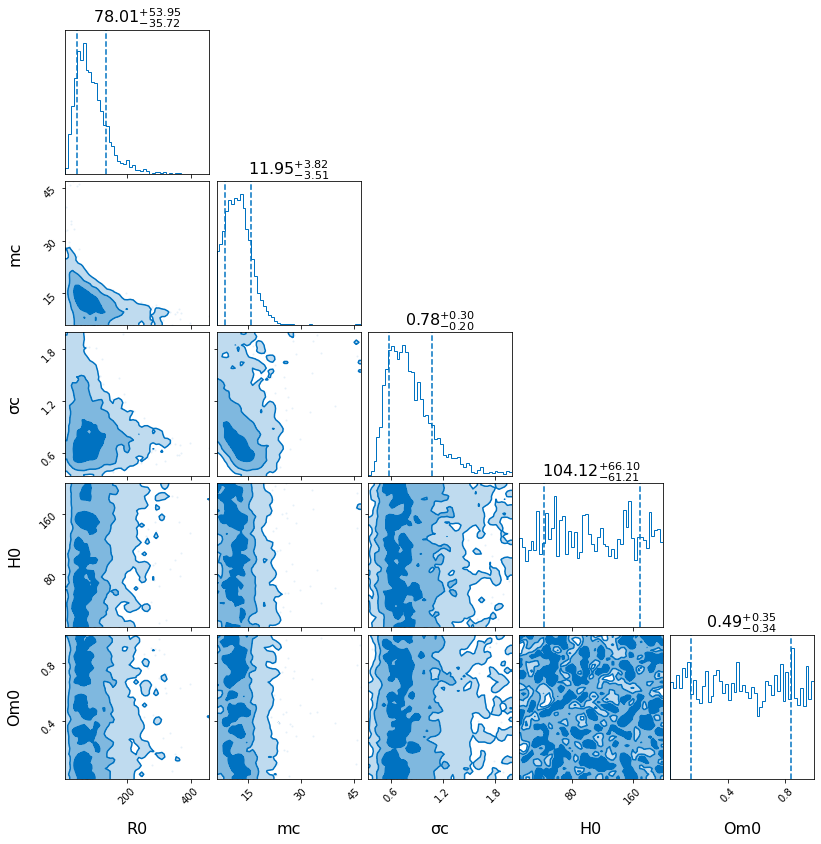

In [18]:
import icarogw
import os
import pickle
import bilby
from icarogw.analyses.cosmo_pop_rate_marginalized import hierarchical_analysis

# Number of injections to use
outdir='H0_GWTC-1_PL_2/'
injections.update_cut(snr_cut=12,ifar_cut=0) # We are going to update the injections with the new SNR cut to 12

# Read the posterior samples
posterior_dict = {}
for event in list(list_ev.keys()):
    print(event)    
    filename = event+'_GWTC-1.hdf5'
        
    pos_samples = posterior_samples(filename)
    posterior_dict[event] = pos_samples

# Setup the priors here. We are going to sample on just H0 and the maximum BH mass for a powerlaw model, just to speed up the code and fixing all the parameters
prior_dict = initialize_prior_dict('PBH-lognormal', 'flatLCDM', 'PBH', False)
# prior_dict['mc'] = 20
# prior_dict['σc'] = 0.5
# prior_dict['Om0']=0.308

analysis = hierarchical_analysis(posterior_dict,injections,scale_free=False)

# Run bilby.  Here we will be using emcee
result = analysis.run_bilby('PBH-lognormal', 'flatLCDM', 'PBH', prior_dict, parallel=2000, nlive=500, nact=2, walks=20, outdir=outdir, label='dynesty_3')
result.plot_corner()